# Using GPU

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
assert device_name == '/device:GPU:0'
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet

In [3]:
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: GeForce GTX 1080 Ti


# Import dataset

In [4]:
import numpy as np
import pandas as pd

# Load 78k dataset
df = pd.read_csv('data/78k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df)))

# Show a few samples
df.sample(3)

Number of data entries: 78056


,text,class
6263,Grubby掀彪悍大破凤凰ReMinD 1 2011初始ECL领衔魔兽巅峰赛事第弹刚刚...,游戏
76321,实 1000元学生数码相机推荐 数码产品日益流行天款?造型时尚机身便携卡片数码相机对学...,科技
15685,詹天佑双色球09126期分布图头码荐02 二区热出 基本号码推荐红球推荐02 03 09 1...,彩票


In [5]:
# Label Encdoing
class_map={'科技':0, '股票':1, '体育':2, '娱乐':3, '时政':4,
          '社会':5, '教育':6, '财经':7, '家居':8, '游戏':9,
          '房产':10, '时尚':11,'彩票':12, '星座':13}

# Mapping the class names
df['class'] = df['class'].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df['class'])

# Experiment settings
100 samples from class 0 - 11 || 100 samples from class 12 || 100 samples from class 13

In [6]:
ls_sample_size = [100, 100, 100]

# class 13
class_rare = 13
df_rare = df[df['class'] == class_rare].sample(ls_sample_size[2])

# class 12
class_mild = 12
df_mild = df[df['class'] == class_mild].sample(ls_sample_size[1])

# Concat the first two dataframes
df_sample = pd.concat((df_rare, df_mild))

# Import samples from the other classes
for i in range(12):
    df_temp = df[df['class'] == i].sample(ls_sample_size[0])
    df_sample = pd.concat((df_sample, df_temp))

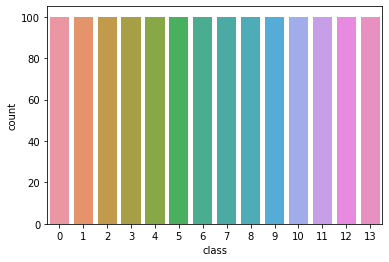

In [7]:
# Show df_sample class distribution
sns.countplot(df_sample['class'])

# Train, valid and test split

In [8]:
from sklearn.model_selection import train_test_split

# Extra 20% for testing
df_train, df_val = train_test_split(df_sample,
                                    test_size=0.2,
                                    random_state=1,
                                    stratify=df_sample['class'])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

Shape: (1120, 2)
Shape: (280, 2)


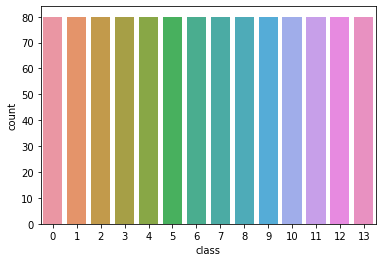

In [9]:
for item in df_train, df_val:
    print('Shape: {}'.format(item.shape))

# Show df_train class distribution    
sns.countplot(df_train['class'])

# Tokenization

In [10]:
!pip install transformers --quiet

In [11]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

In [12]:
# Create lists for encoded text data
def get_encoded_dict(df):
    input_ids = []
    attention_mask = []

    for text in df['text']:
        encoded = tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        pad_to_max_length=True,
                                        return_attention_mask=True,
                                        max_length=128,
                                        return_tensors='pt',
                                        truncation=True)

        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
        
    return input_ids, attention_mask

In [13]:
# Cat lists to tensors for TensorDataset
def get_tensors(input_ids, attention_mask):
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    
    return input_ids, attention_mask

# Dataset and DataLoader

In [14]:
# Import tools for Dataloader
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

# Convert df to DataLoader
def get_dataloader(df, batch_size=32):
    temp_ids, temp_masks = get_encoded_dict(df)
    
    # Convert to tensors
    temp_ids, temp_masks = get_tensors(temp_ids, temp_masks)
    temp_labels = torch.tensor(df['class'].values)
    
    # Generate dataset
    temp_dataset = TensorDataset(temp_ids,
                                 temp_masks,
                                 temp_labels)
    
    # Generate dataloader
    temp_dataloader = DataLoader(temp_dataset,
                                 batch_size=batch_size,
                                 sampler=RandomSampler(temp_dataset))
    
    return temp_dataloader

In [15]:
# Get dataloader for all dataframes
train_dataloader = get_dataloader(df_train)
val_dataloader = get_dataloader(df_val)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Import BERT model

In [16]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-chinese',
                                                      num_labels=14,
                                                      output_attentions=False,
                                                      output_hidden_states=False)
# Tell mode to use CUDA
model.cuda()

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# Configuring optimizer
optimizer = AdamW(model.parameters(),
                  lr = 3e-5)

In [18]:
# Configuring scheduler
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total steps: number of batchers * epochs
total_steps = len(train_dataloader) * epochs

# Set up the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=10,
                                            num_training_steps=total_steps)

# Training

In [19]:
# Import materics for evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [20]:
# Reset history lists
history_training_loss = []
history_val_loss = []
history_val_acc = []

for epoch_i in range(epochs):
    
    print('【EPOCH: {}/ {}】'.format(epoch_i+1, epochs))
    print('Trainig Phase')
    
    # Set training mode
    model.train()
    
    # Reset training loss
    total_training_loss = 0.
    
    # Batch and forward
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        # Reset gradients before 
        model.zero_grad()
        
        # Forward pass
        res = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_masks,
                    return_dict=True,
                    labels=b_labels)
        
        loss = res.loss
        logits = res.logits
        
        # sumup training loss
        total_training_loss += loss.item()
        
        # backpropagation
        loss.backward()
        
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer and scheduler
        optimizer.step()
        scheduler.step()
        
    # averrage loss
    avg_train_loss = total_training_loss/len(train_dataloader)
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    
    # append the loss data to history
    history_training_loss.append(avg_train_loss)
    
    # validation
    print('Validation Phase')
    
    # Reset validation loss
    total_val_loss = 0
    
    # Set up lists
    ls_val_logits = []
    ls_val_labels = []

    # Get batchs from val_dataloader
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        # No need to calculate gradients
        with torch.no_grad():

            res = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_masks,
                        labels=b_labels,
                        return_dict=True)

        val_loss = res.loss
        val_logits = res.logits
        total_val_loss += val_loss.item()

        # Convert logitis to numpy format
        val_logits = np.argmax(val_logits.cpu().detach().numpy(), axis=1)
        val_labels = b_labels.cpu().detach().numpy()

        # Append data to the lists
        for logit in val_logits:
            ls_val_logits.append(logit)

        for label in val_labels:
            ls_val_labels.append(label)
    
    # Get accuracy score and val_loss
    acc = accuracy_score(ls_val_logits, ls_val_labels)
    avg_val_loss = total_val_loss/len(val_dataloader)
    
    # append validation data to history
    history_val_acc.append(acc)
    history_val_loss.append(avg_val_loss)
    
    # Print out validation performance
    print('  Average validation loss: {:.4f}'.format(avg_val_loss))
    print('  Validation accruacy: {:.4f}'.format(acc))
    print('\n')

【EPOCH: 1/ 3】
Trainig Phase
  Average training loss: 2.0952
Validation Phase
  Average validation loss: 1.1732
  Validation accruacy: 0.8786


【EPOCH: 2/ 3】
Trainig Phase
  Average training loss: 0.7767
Validation Phase
  Average validation loss: 0.4961
  Validation accruacy: 0.9536


【EPOCH: 3/ 3】
Trainig Phase
  Average training loss: 0.3796
Validation Phase
  Average validation loss: 0.4022
  Validation accruacy: 0.9429




# Training and evaluation performance

In [21]:
# Convert histroy to dataframe
cols = ['loss', 'val_loss', 'val_acc']

history = np.stack((
                    np.array(history_training_loss),        
                    np.array(history_val_loss),
                    np.array(history_val_acc),
                    ), axis=1)

df_history = pd.DataFrame(history, columns=cols)

# Show df_history
df_history

,loss,val_loss,val_acc
0,2.095235,1.173236,0.878571
1,0.776724,0.496104,0.953571
2,0.379642,0.402195,0.942857


Text(0.5, 1.0, 'accuracy')

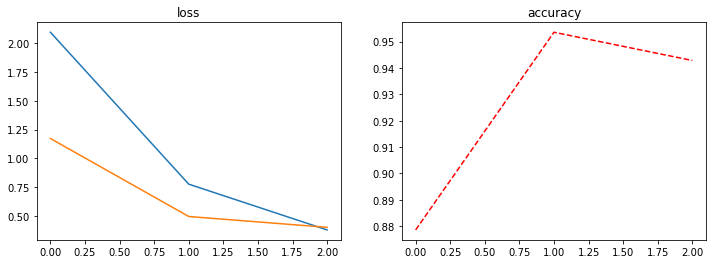

In [22]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(df_history['loss'])
plt.plot(df_history['val_loss'])
plt.title('loss')

plt.subplot(1,2,2)
plt.plot(df_history['val_acc'], color='red', linestyle='--')
plt.title('accuracy')

# Saving the model

In [23]:
PATH = 'model/B_100_EP3.pt'

torch.save(model.state_dict(), PATH)

# Perform on the test data

#### # Prepare test_dataloder from 125k dataset 

In [24]:
# Load 125k dataset
df_test = pd.read_csv('data/125k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df_test)))

# Mapping class to number
df_test['class'] = df_test['class'].map(class_map)

# Show a few samples
df_test.sample(3)

Number of data entries: 125412


,class,text
51861,5,抢劫团伙按抢金项链数量推选头目本报讯记者 周雪莲听说重庆 遍地钱5名广西少年竟结伴市抢劫单身...
1538,2,图文-汇丰冠军赛第二轮赛况 莫里纳利过桥新浪体育讯11月5日海消息 2010年高夫世锦赛-汇...
103568,3,张柏芝复拍广告位日前张柏芝低调广州拍摄广告悉张柏芝要求次拍摄定要低调处理拍摄场地选广州间摄影...


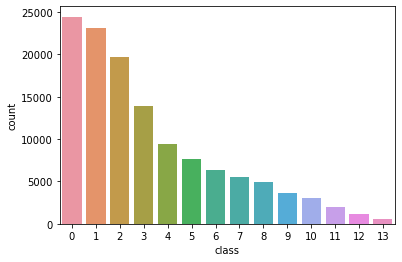

In [25]:
# Show df_test class disctribution
sns.countplot(df_test['class'])

In [26]:
# Prepare df_test for prediction
t_input_ids, t_attention_mask = get_encoded_dict(df_test)
t_input_ids, t_attention_mask = get_tensors(t_input_ids, t_attention_mask)

# Prepare dataset and dataloader
test_dataset = TensorDataset(t_input_ids, t_attention_mask)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             sampler=SequentialSampler(test_dataset))

# Show dataloader length
print('Number of batches in the dataloader: {}'.format(len(test_dataloader)))

Number of batches in the dataloader: 3920


In [27]:
# Setup lists for predictions and labels
ls_test_pred = []

# Get batchs from test_dataloader
for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_masks = batch[1].to(device)
    
    with torch.no_grad():

        res = model(b_input_ids,
                    attention_mask=b_masks,
                    return_dict=True)

        test_logits = res.logits
        test_logits = np.argmax(test_logits.cpu().detach().numpy(), axis=1)
        
        for pred in test_logits:
            ls_test_pred.append(pred)
            
print(len(ls_test_pred))

125412


In [28]:
# Set up list of test labels
ls_test_labels = list(df_test['class'].values)

# Get accuracy score and val_loss
acc = accuracy_score(ls_test_pred, ls_test_labels)
print('Prediction accuracy: {:.4f}'.format(acc))

Prediction accuracy: 0.8177


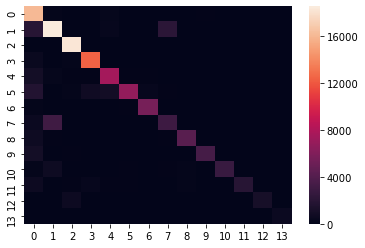

In [29]:
# Confusion matrix
cm = confusion_matrix(ls_test_pred, ls_test_labels)

sns.heatmap(cm)

In [30]:
# Classification report
cr = classification_report(ls_test_pred, ls_test_labels)

print(cr)

              precision    recall  f1-score   support

           0       0.66      0.96      0.78     16901
           1       0.80      0.80      0.80     23121
           2       0.93      0.99      0.96     18446
           3       0.90      0.93      0.91     13438
           4       0.80      0.82      0.81      9271
           5       0.90      0.62      0.74     10990
           6       0.90      0.91      0.90      6183
           7       0.55      0.45      0.49      6813
           8       0.87      0.79      0.83      5413
           9       0.93      0.74      0.82      4595
          10       0.92      0.67      0.77      4150
          11       0.96      0.54      0.69      3580
          12       0.97      0.59      0.74      1852
          13       0.97      0.79      0.87       659

    accuracy                           0.82    125412
   macro avg       0.86      0.76      0.79    125412
weighted avg       0.83      0.82      0.81    125412



# Export training history

In [31]:
df_history.to_csv('history/B_100_EP3.csv')

In [ ]:
df_history